Derivative of a simple function with one input

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

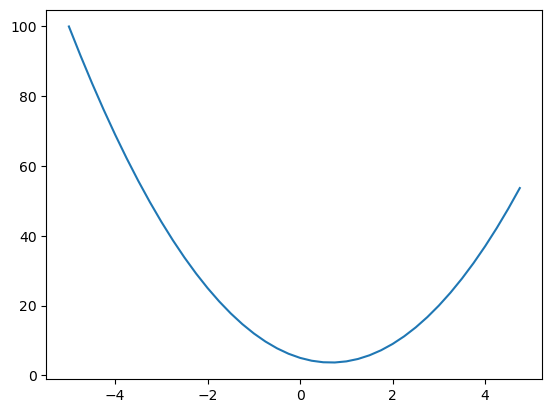

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [5]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

Derivative of a function with multiple inputs

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [52]:
# starting the core Value object of micrograd and its visualization
class Value:
    # Wrapping numbers in objects lets us track operations and compute gradients (needed for training neural networks)
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data  # Store the actual number value
        self.grad = 0  # Stores the gradient (how much this Value affects the final output)
        self._prev = set(_children)  # Tracks which Values were used to create this Value (for building computation graph)
        self._op = _op  # Records which arithmetic operation created this Value
        self.label = label  # Human-readable name for visualization
        self._backward = 
    
    # __repr__ shows what's inside the object when printed (instead of memory address)
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Python has no idea what eg; Value(2) + Value(3) should do until you tell it via __add__(), __mul__(), etc.
    # (self, other): pass parent Values so result remembers where it came from
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    # tanh takes one input (self), so parent tuple is (self,) - comma makes single-element tuple
    # Formula: (e^2x - 1)/(e^2x + 1) squashes any number to range [-1, 1] for neuron activation
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")
        return out

# Create input values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Build computation graph
e = a*b; e.label = 'e'  
d = e + c; d.label = 'd'  
f = Value(-2.0, label = "f")
L = d * f; L.label = "L"  
d

Value(data=4.0)

In [53]:
#graphic visualization library

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

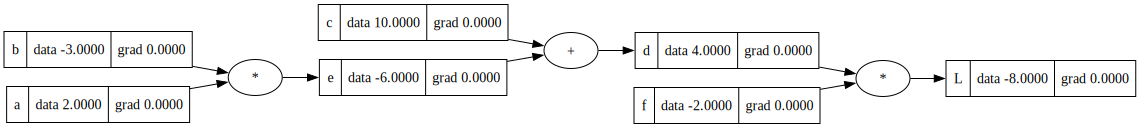

In [54]:
draw_dot(L)

Manual backpropagation #1: simple expression

In [55]:
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4

Manual backpropagation #2: a neuron

In [61]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"

In [66]:
o.grad = 1
b.grad = 0.5
n.grad = 0.5
x1w1x2w2.grad = 0.5 
x2w2.grad = 0.5
x1w1.grad = 0.5 
x1.grad = -1.5
x2.grad = 0.5
w1.grad = 1
w2.grad = 0

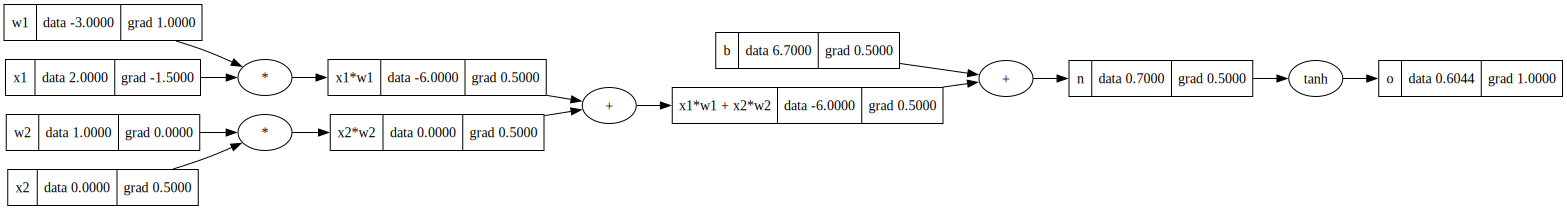

In [67]:
draw_dot(o)